In [1]:
## Import libraries and useful functions

suppressMessages({
  library(ggplot2)
  library(terra)
  library(leaflet)
  library(tidyr)
  library(dplyr)
})

library(ggplot2)
library(terra)
library(leaflet)
library(tidyr)
library(dplyr)

source("../scripts/utils.R")

In [2]:
## Set paths and load data
# Input NVDI basemaps stored in country folder. 
# Area of Interest (AoI) files in AoI folder

country_name <- "Zambia"
data_type <- "NDVI"
resolution <- 100 # in meters
data_path <- paste0("../data/", data_type, "/", country_name, "/", resolution, "m_resolution/")
aoi_path <- "../data/AoI/"

test_year <- 2024


In [3]:
## Create lists with relevant filenames.
## Extract date, and order accordingly

# NDVI filenames
ndvi_files <- get_filenames(filepath = data_path, data_type = data_type, 
                            file_extension = ".tif", country_name = country_name)

# AoI filenames
aoi_files <- get_filenames(filepath = aoi_path, data_type = "AoI", 
                           file_extension = ".geojson", country_name = country_name)

# Extract the date part from the filenames using a regular expression
# Assumes only year and month in filename
dates <- extract_dates(file_list = ndvi_files)

# Convert extracted date strings to date objects
# sorting files based on the date objects (ascending)
ndvi_files <- order_by_date(file_list = ndvi_files, dates = dates, decreasing = FALSE)


Loading NDVI data for Zambia 

Loading AoI data for Zambia 

Found data for 72 months, from 2019-01 to 2024-12 



Loading AoI data for Zambia 

Found data for 48 months, from 2020-01 to 2023-12 


In [4]:
## Load raster and vector objects

# load raster data for all months, and stack
ndvi_rast <- terra::rast(paste0(data_path, ndvi_files))

# load input Area of Interest (AoI) to later mask data
aoi_vec <- sf::st_read(paste0(aoi_path, aoi_files))

Reading layer `AoI_Mponda' from data source 
  `/home/user/data/AoI/AoI_Zambia_By_Life_Connected.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1 feature and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 26.77027 ymin: -15.1321 xmax: 26.92342 ymax: -14.85555
Geodetic CRS:  WGS 84


In [5]:
## Transform (by projecting) the raster and AoI data to useful coordinate system

# Common transformations: project a raster
# see https://epsg.io/ for projection systems
ndvi_proj <- terra::project(ndvi_rast, "EPSG:4326") 
aoi_proj <- sf::st_transform(aoi_vec, "EPSG:4326") 

In [6]:
## Mask the raster, to remove background values (if any).
ndvi_msk <- terra::mask(ndvi_proj, aoi_proj)

# change layer names for plotting
names(ndvi_msk) <- c(dates)


In [7]:
# add time info for transformations
time(ndvi_msk) <- as.Date(paste0(dates, "-01"))

In [8]:
# Extract raster layers for each date
# and store in dataframe
raster_dfs <- lapply(as.Date(paste0(dates, "-01")), function(date_key) {
  raster_layer <- ndvi_msk[[time(ndvi_msk) == date_key]]
  raster_to_df(raster_layer, date_key)
})

# Combine all data frames into one bigger one
ndvi_df <- bind_rows(raster_dfs)

In [9]:
# split dates into month and year columns
ndvi_df <- transform(ndvi_df, Year = format(YearMonth, "%Y"), Month = format(YearMonth, "%m"))


In [10]:
## now split df into train and test data
# train year data
train_ndvi_df <- ndvi_df[ndvi_df$Year != test_year,]
# test year data
test_ndvi_df <- ndvi_df[ndvi_df$Year == test_year,]

In [11]:
# drop missing values
train_ndvi_df <- na.omit(train_ndvi_df)
test_ndvi_df <- na.omit(test_ndvi_df)

# and change column name for plotting
colnames(train_ndvi_df)[3] <- data_type
colnames(test_ndvi_df)[3] <- data_type

In [12]:
## Compute mean, SD, and confidence intervals
# train data
train_ndvi_summary <- train_ndvi_df %>%
  group_by(Year, Month) %>%
  summarize(mean_ym_ndvi = mean(NDVI)) %>% # first get the monthly mean NDVI, for each year separately
  group_by(Month) %>%
  summarize(
    mean_val = mean(mean_ym_ndvi),
    lower_ci = mean(mean_ym_ndvi) - 1.96 * sd(mean_ym_ndvi) / sqrt(length(mean_ym_ndvi)), # 95% CI lower bound
    upper_ci = mean(mean_ym_ndvi) + 1.96 * sd(mean_ym_ndvi) / sqrt(length(mean_ym_ndvi)) # 95% CI upper bound
  )
# test data
test_ndvi_summary <- test_ndvi_df %>%
  group_by(Year, Month) %>%
  summarize(mean_ym_ndvi = mean(NDVI)) %>% # first get the monthly mean NDVI, for each year separately
  group_by(Month) %>%
  summarize(
    mean_val = mean(mean_ym_ndvi),
    lower_ci = mean(mean_ym_ndvi) - 1.96 * sd(mean_ym_ndvi) / sqrt(length(mean_ym_ndvi)), # 95% CI lower bound
    upper_ci = mean(mean_ym_ndvi) + 1.96 * sd(mean_ym_ndvi) / sqrt(length(mean_ym_ndvi)) # 95% CI upper bound
  )

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


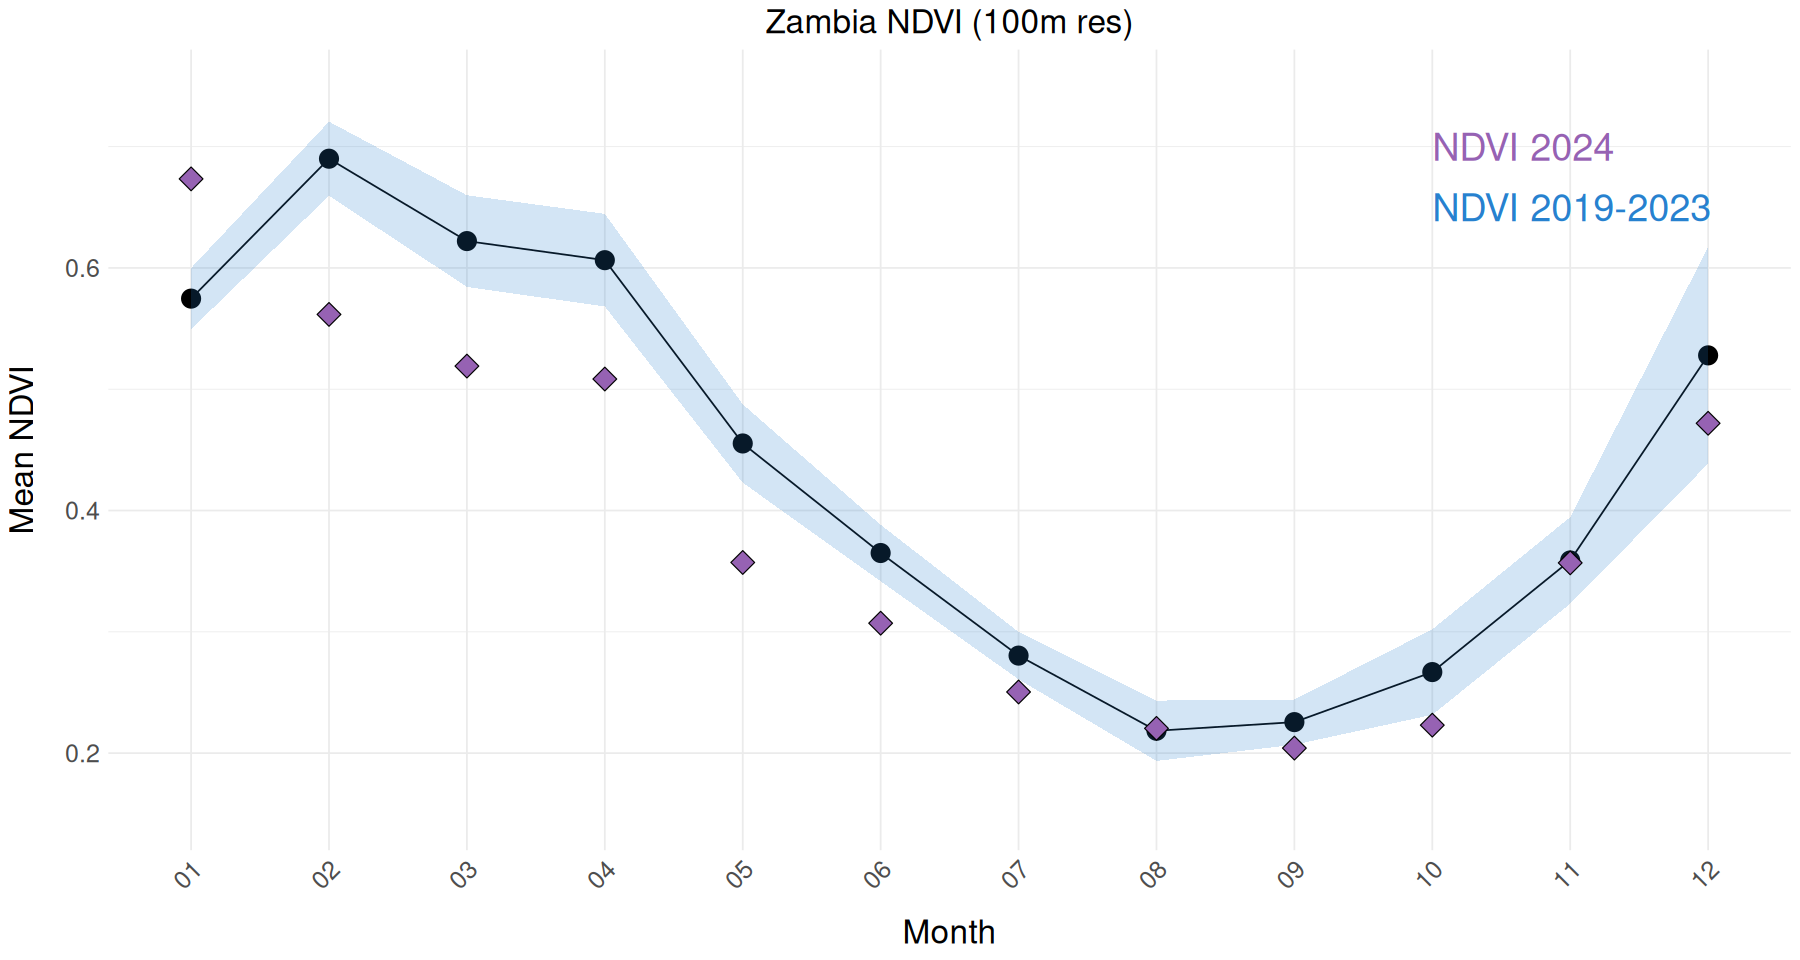

In [13]:
## Inspect distribution of NDVI values throughout the year.

# Plot timeseries mean values 
# with shaded ribbon for confidence interval

# Change plot size to 15 x 8
options(repr.plot.width=15, repr.plot.height=8)

# actually plot timeseries
ggplot(NULL, aes(x = Month, y = mean_val, group = 1)) +
  geom_point(data = train_ndvi_summary, size = 5, fill = "#2781cf") + # point-average train data
  geom_line(data = train_ndvi_summary) +
  geom_ribbon(data = train_ndvi_summary, aes(ymin = lower_ci, ymax = upper_ci), alpha = 0.2, fill = "#2781cf") + # Shaded CI ribbon
  geom_point(data = test_ndvi_summary, size = 5, shape=23, fill = "#9662b3") + # point-average test data
  theme_minimal() +
  labs(
    title = paste0(country_name, " NDVI (", resolution, "m res)"),
    x = "Month", 
    y = "Mean NDVI"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15), 
        axis.text.y = element_text(size = 15), 
        axis.title.x = element_text(size = 20, margin = margin(15,0,0,0)),
        axis.title.y = element_text(size = 20, margin = margin(0,15,0,0)),
       plot.title = element_text(size = 20, hjust = 0.5)) +
  ylim(0.15, .75) +
  geom_text(x=10, y=.7, label="NDVI 2024", size = 8, color = "#9662b3", hjust=0) + # add text to label plot
geom_text(x=10, y=.65, label="NDVI 2019-2023", size = 8, color = "#2781cf", hjust=0) # add text to label plot

In [14]:
#train_ndvi_summary

In [15]:
## plot version with weighted mean (to account for missing values in raster)

# get x and y dimensions of raster
map_dim <- dim(ndvi_msk)

# get number of cells of raster
num_cells <- map_dim[1] * map_dim[2]

In [16]:

# make new summary df
## Compute mean, SD, and confidence intervals
# train data
Wtrain_ndvi_summary <- train_ndvi_df %>%
  group_by(Year, Month) %>%
  summarize(
      mean_ym_ndvi = mean(NDVI), # first get the monthly mean NDVI, for each year separately
      weights_ym_ndvi = length(NDVI)/num_cells) %>% # calculate what percentage of map points are being used to get mean
  group_by(Month) %>%
  summarize(
    mean_val = weighted.mean(mean_ym_ndvi, weights_ym_ndvi),
    lower_ci = mean(mean_ym_ndvi) - 1.96 * sd(mean_ym_ndvi) / sqrt(length(mean_ym_ndvi)), # 95% CI lower bound
    upper_ci = mean(mean_ym_ndvi) + 1.96 * sd(mean_ym_ndvi) / sqrt(length(mean_ym_ndvi)) # 95% CI upper bound
  )

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


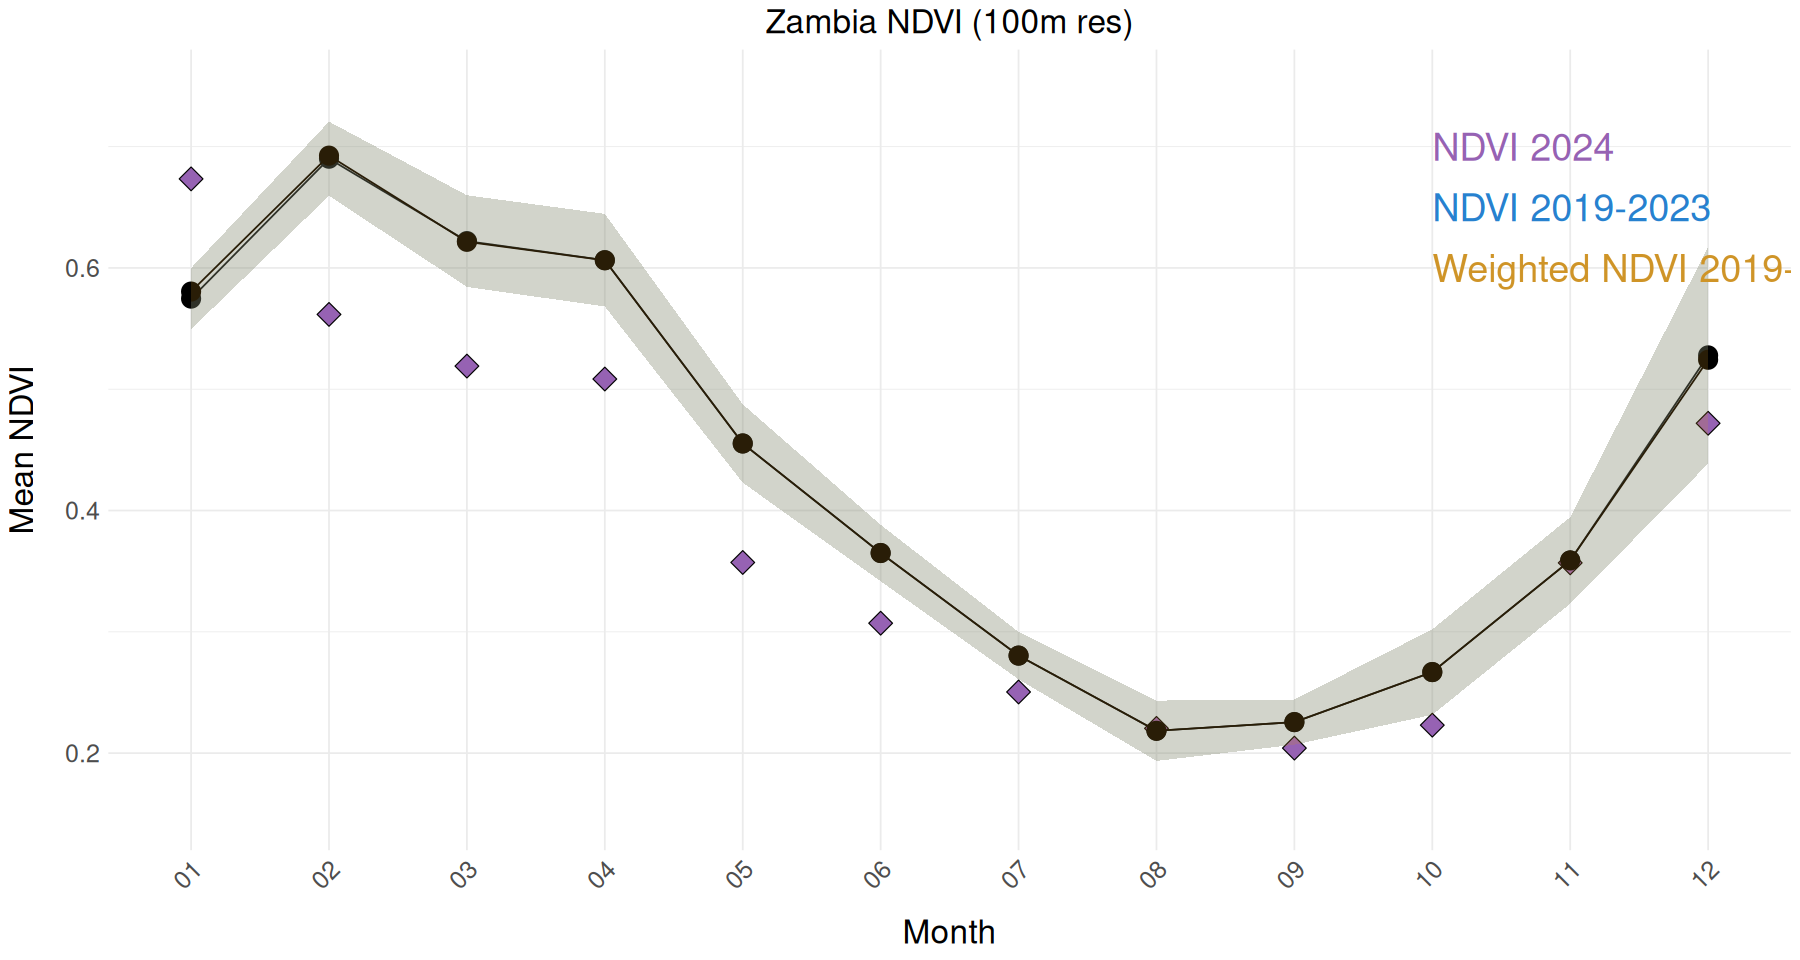

In [17]:
# Plot timeseries mean values 
# with shaded ribbon for confidence interval

# Change plot size to 15 x 8
options(repr.plot.width=15, repr.plot.height=8)

# actually plot timeseries
ggplot(NULL, aes(x = Month, y = mean_val, group = 1)) +
  geom_point(data = train_ndvi_summary, size = 5, fill = "#2781cf") + # point-average train data
  geom_line(data = train_ndvi_summary) +
  geom_ribbon(data = train_ndvi_summary, aes(ymin = lower_ci, ymax = upper_ci), alpha = 0.2, fill = "#2781cf") + # Shaded CI ribbon
  geom_point(data = test_ndvi_summary, size = 5, shape=23, fill = "#9662b3") + # point-average test data
 geom_point(data = Wtrain_ndvi_summary, size = 5, fill = "#cf9427") + # point-average WEIGHTED MEAN train data
  geom_line(data = Wtrain_ndvi_summary) +
  geom_ribbon(data = Wtrain_ndvi_summary, aes(ymin = lower_ci, ymax = upper_ci), alpha = 0.2, fill = "#cf9427") + # Shaded CI ribbon
  theme_minimal() +
  labs(
    title = paste0(country_name, " NDVI (", resolution, "m res)"),
    x = "Month", 
    y = "Mean NDVI"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15), 
        axis.text.y = element_text(size = 15), 
        axis.title.x = element_text(size = 20, margin = margin(15,0,0,0)),
        axis.title.y = element_text(size = 20, margin = margin(0,15,0,0)),
       plot.title = element_text(size = 20, hjust = 0.5)) +
  ylim(0.15, .75) +
  geom_text(x=10, y=.7, label="NDVI 2024", size = 8, color = "#9662b3", hjust=0) + # add text to label plot
geom_text(x=10, y=.65, label="NDVI 2019-2023", size = 8, color = "#2781cf", hjust=0) + # add text to label plot
geom_text(x=10, y=.6, label="Weighted NDVI 2019-2023", size = 8, color = "#cf9427", hjust=0) # add text to label plot